In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "./forcing.zarr"
path_to_obs_hot = "../../../1_data_processing/1_1_Forcing/products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
path_to_obs_barents = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/zoo_2000_2017.zarr"
export_file_name = "SeapoPym_climato_hot_barents_2_groups"

In [3]:
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"
LATITUDE = 22.75
LONGITUDE = -158
STABILIZATION_DAYS = 90
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["temperature"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 424kB
Dimensions:              (depth: 3, latitude: 2, longitude: 2, time: 1827)
Coordinates: (4)
Data variables: (3)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[114.84210764968468 nan] [nan 154.8514838879948]] [[113.10354321928514 nan] [nan 155.16812711459391]] [[114.18750083099961 nan] [nan 155.4294606990115]] ... [[113.9499935505495 nan] [nan 152.39512719007502]] [[113.55127089450652 nan] [nan 152.72394211786622]] [[114.84210764968468 nan] [nan 153.024833731158]]]
Units,meter


<!-- ## Observed NPP -->


### Observations


In [6]:
observations_hot = xr.open_zarr(path_to_obs_hot).load()
observations_hot = observations_hot.resample(time="1D").interpolate("linear").dropna("time")
observations_hot = observations_hot.sel(time=slice(TIME_START, TIME_END))
observations_hot = observations_hot.pint.quantify().pint.to("mg/m^3")
observations_hot = observations_hot * epi_layer_depth
observations_hot = observations_hot.drop_vars("depth")
observations_hot = observations_hot[["day", "night"]]
observations_hot

Magnitude,[[[[175.0393382017864]]] [[[171.91155568709888]]] [[[173.07662716509964]]] ... [[[174.86090174350818]]] [[[173.55167845591396]]] [[[175.0393382017864]]]]
Units,milligram/meter2
Magnitude,[[[[296.67369635689136]]] [[[290.87722330653037]]] [[[292.3472049493092]]] ... [[[297.288307051414]]] [[[294.6494292157888]]] [[[296.67369635689136]]]]
Units,milligram/meter2


In [7]:
observations_barents = xr.open_zarr(path_to_obs_barents).load()
observations_barents = observations_barents.resample(time="1D").interpolate("linear").dropna("time")
observations_barents = observations_barents.sel(time=slice(TIME_START, TIME_END))
observations_barents = observations_barents.pint.quantify().pint.to("mg/m^2").pint.dequantify()
observations_barents

<xarray.Dataset> Size: 29kB
Dimensions:    (time: 1827, latitude: 1, longitude: 1, layer: 1)
Coordinates: (4)
Data variables: (1)

Remove the X first months to let the model reach the stationary state.


In [8]:
decay = pd.Timestamp(TIME_START) + pd.Timedelta(days=STABILIZATION_DAYS)

observations_hot = observations_hot.sel(time=slice(str(decay), None))
observations_barents = observations_barents.sel(time=slice(str(decay), None))

Create structure for SeapoPym simulation.


In [9]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["temperature"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["primary_production"], resolution=1 / 12, timestep=1),
)

2025-01-28 13:45:05,823 :: Seapodym ::  WARNING ::
|	primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [10]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [11]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_hot), Observation(observations_barents)],
)

Set the genetic algorithm meta parameters.


In [12]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=20,
    POP_SIZE=1000,
    cost_function_weight=(-0.5, -0.5),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [13]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [14]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52092 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [15]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52092/status,
Dashboard: http://127.0.0.1:52092/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52093,Workers: 4
Dashboard: http://127.0.0.1:52092/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:52104,Total threads: 3
Dashboard: http://127.0.0.1:52107/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:52096,


## Run the optimization


In [16]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,106.049417,305.343794,0.002764,3515.312611,1000,0.000
1,7.650531,49.724679,0.000852,1113.885520,1000,0.236
2,4.467885,74.491074,0.002114,2236.876552,1000,0.262
3,0.938612,8.216670,0.001498,161.908054,1000,0.248
4,1.945822,15.781768,0.001498,228.033509,1000,0.230
5,1.934592,17.743879,0.001363,432.538900,1000,0.252
6,3.109387,23.914389,0.001363,491.762411,1000,0.274
7,3.290807,20.776584,0.001363,278.668132,1000,0.275
8,3.416049,24.651916,0.001363,575.919541,1000,0.251


Generations: 100%|██████████| 20/20 [18:18<00:00, 54.90s/it]


## Optimization statistics


In [17]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
14         625                        0.339127    35.348647     -0.006423   
1          831                        0.025775    28.544449     -0.009457   
15         135                        0.339127    40.593006     -0.006423   
           409                        0.339127    35.348647     -0.006423   
14         582                        0.172586    40.593006     -0.029631   
...                                        ...          ...           ...   
0          485                        0.355603    33.482960     -0.297092   
2          662                        0.370631    24.771353     -0.193560   
0          170                        0.293811    18.646914     -0.095772   
           630                        0.364292    49.137819     -0.265732   
           442                        0.368299    47.431477     -0.159621   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
14         625                   51.694391             -0.149658   
1          831                  210.109297             -0.088082   
15         135                   51.694391             -0.149658   
           409                   51.694391             -0.149658   
14         582                   37.712604             -0.101977   
...                                    ...                   ...   
0          485                  349.401928             -0.009182   
2          662                  383.034422             -0.012537   
0          170                  486.929599             -0.008421   
           630                  380.146547             -0.008034   
           442                  479.569723             -0.010104   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
14         625                        0.353175    46.498939     -0.001514   
1          831                        0.043892    20.309355     -0.284057   
15         135                        0.353175    46.498939     -0.001514   
           409                        0.353175    39.799951     -0.001813   
14         582                        0.399383    46.498939     -0.001813   
...                                        ...          ...           ...   
0          485                        0.115699    19.861757     -0.242490   
2          662                        0.096677    33.303383     -0.032556   
0          170                        0.192579    45.916394     -0.106056   
           630                        0.205494    10.812935     -0.246968   
           442                        0.011499    25.243764     -0.273402   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate      fitness  
generation individual                                                          
14         625                   69.440934             -0.265055     0.000844  
1          831                   56.907097             -0.100426     0.000852  
15         135                   69.440934             -0.265055     0.000890  
           409                   69.440934             -0.265055     0.000916  
14         582                    5.057912             -0.144552     0.001090  
...                                    ...                   ...          ...  
0          485                   23.237526             -0.080130  2023.969019  
2          662                  241.527706             -0.244189  2236.876552  
0          170                   97.802793             -0.252712  2434.267636  
           630                  319.005816             -0.090533  2845.753065  
           442                   83.664919             -0.112028  3515.312611  

[15274 rows x 11 columns]

In [18]:
viewer.fitness_evolution()

In [19]:
viewer.box_plot(3, nbest=1000)

In [20]:
fig = viewer.parallel_coordinates(500, unselected_opacity=0)
fig

In [21]:
if SAVE:
    fig.write_html(f"Parallel_coordinates_{export_file_name}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [22]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [23]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [24]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.3391271114047479, 35.34864700884822, -0.006422740036256612, 51.6943914200087, -0.1496577406938696]
Best individual: [1.0, 0.0, 0.3531746589459046, 46.49893932543334, -0.001514282522827648, 69.44093434122873, -0.2650546952440779]


In [25]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

best_model.run()

And with the X best individuals :


In [26]:
NB_INDIVIDUAL_TO_SHOW = 10

min_biomass_D1N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=0).data.flatten()
)
max_biomass_D1N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=0).data.flatten()
)
min_biomass_D2N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=1).data.flatten()
)
max_biomass_D2N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=1).data.flatten()
)

biomass_accumulated = []

for cpt in range(0, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["D1N1", "D2N1"]),
    )
    model.run()

    biomass_accumulated.append(
        model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).expand_dims({"individual": [cpt]})
    )

In [27]:
with xr.set_options(keep_attrs=True):
    best_individuals_simulations = xr.concat(biomass_accumulated, dim="individual")
    min_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).max("individual").isel(latitude=0, longitude=0)
    )
    min_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).max("individual").isel(latitude=0, longitude=0)
    )

### Format the results


Convert to pandas series.


In [28]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations_hot.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .day.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["day"]
)
observations_night_pandas = (
    observations_hot.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = (
    epi_layer_depth.sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.dequantify()
    .to_dataframe()
    .reset_index()
    .set_index("time")["pelagic_layer_depth"]
)

Then resample to month.


In [29]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [41]:
NB_INDIVIDUAL_CORRELATION = 1000

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [42]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [32]:
x = best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).time.to_series()
x_rev = pd.concat([x, x[::-1]])

fig = go.Figure()

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

# D2N1 data
y_D2N1 = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .sel(functional_group=1)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
) + y_D1N1
y_D2N1_upper = max_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2") + y_D1N1_upper
y_D2N1_lower = min_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1] + y_D1N1_lower
y_D2N1_rev = np.concatenate([y_D2N1_upper, y_D2N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# D2N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D2N1_rev,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D2N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D2N1,
        line_color="rgb(0,176,246)",
        name="D2N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=observations_hot.day.time.data.flatten(),
        y=observations_hot.day.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines",
        name="Day observations",
        line={"dash": "dash", "color": "firebrick", "width": 1},
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_hot.night.time.data.flatten(),
        y=observations_hot.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.sel(latitude=[LATITUDE], longitude=[LONGITUDE]).primary_production.time.data.flatten(),
        y=best_model.state.sel(latitude=[LATITUDE], longitude=[LONGITUDE])
        .primary_production.pint.quantify()
        .pint.to("mg/m2/day")
        .pint.dequantify()
        .data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [33]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [34]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# DAY ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(255,0,0)"},
        name="Predictions Day",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill="tonextx",
        fillcolor="rgba(255,0,0,0.15)",
        mode="lines+markers",
        line={"color": "firebrick", "dash": "dash", "width": 1},
        name="Observations (day)",
    )
)
# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonextx",
        fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [35]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.9044089704911034, 0.9659660149608702, 0.6271951939522783, 0.6602819955856892]
norm STD [0.7779040722342752, 1.075715020633574, 1.1716095758326126, 1.0050060814366548]
bias [0.0324320552782076, 0.04371591687741355, 0.8313133290850665, -1.7119124282142724]
NRMSE [0.44502573338874835, 0.28098843781686755, 0.9502700710226071, 0.826354876352263]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


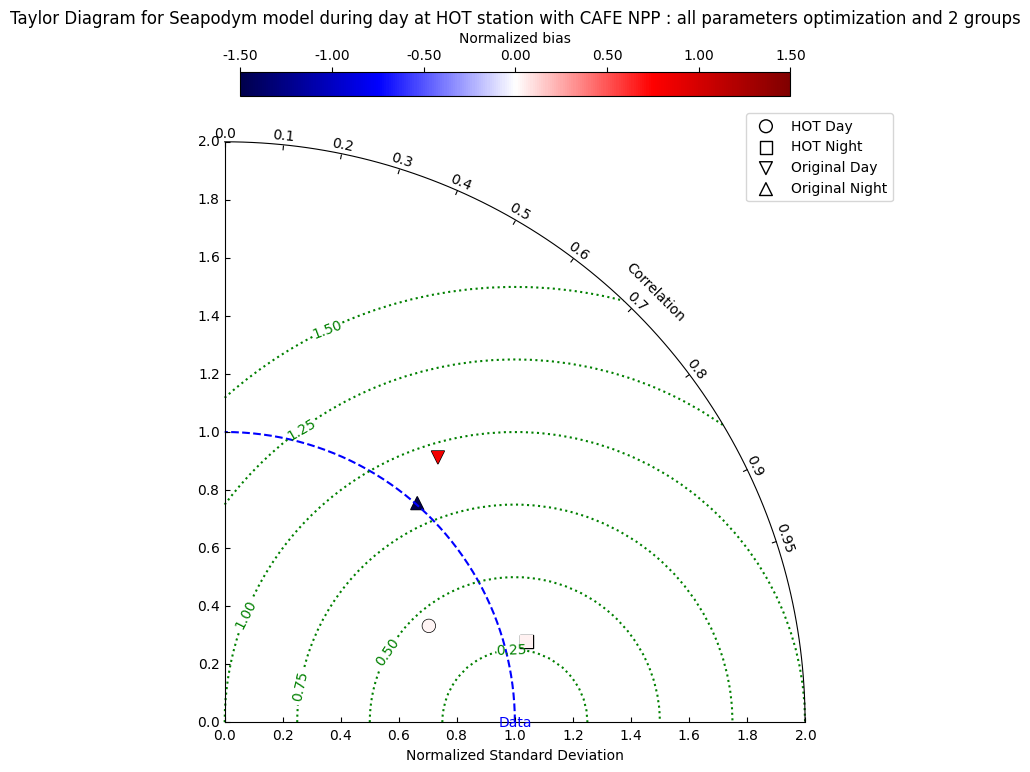

In [36]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [37]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.904409,0.777904,0.032432,0.445026
1,HOT Night,0.965966,1.075715,0.043716,0.280988
2,Original Day,0.627195,1.171610,0.831313,0.950270
3,Original Night,0.660282,1.005006,-1.711912,0.826355


### Telagrand diagram


In [38]:
# Quantify and convert observations to mg/m2
obs_day = (
    observations_hot.day.isel(latitude=0, longitude=0, layer=0).pint.quantify().pint.to("mg/m2").pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert predictions to mg/m2
pred_day = (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=0)
    .sel(time=obs_day.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for day observations
all_ranks_day = []
for time_ite in obs_day.time:
    pred_day_ite = np.sort(pred_day.sel(time=time_ite).data)
    obs_day_ite = float(obs_day.sel(time=time_ite))
    rank = np.searchsorted(pred_day_ite, obs_day_ite)
    all_ranks_day.append(rank)

# Quantify and convert night observations to mg/m2
obs_night = (
    observations_hot.night.isel(latitude=0, longitude=0, layer=0).pint.quantify().pint.to("mg/m2").pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert night predictions to mg/m2
pred_night = pred_day + (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=1)
    .sel(time=obs_night.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for night observations
all_ranks_night = []
for time_ite in obs_night.time:
    pred_night_ite = np.sort(pred_night.sel(time=time_ite).data)
    obs_night_ite = float(obs_night.sel(time=time_ite))
    rank = np.searchsorted(pred_night_ite, obs_night_ite)
    all_ranks_night.append(rank)

In [39]:
fig = go.Figure()


value, count = np.unique(all_ranks_day, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Day Ranks",
        marker_color="firebrick",
        opacity=0.75,
    )
)

value, count = np.unique(all_ranks_night, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Night Ranks",
        marker_color="royalblue",
        opacity=0.75,
    )
)

# Update layout
fig.update_layout(
    title="Histogram of Ranks for Day and Night",
    xaxis_title="Rank",
    yaxis_title="P(Rank)",
    barmode="group",
)

fig.show()

In [40]:
fig.write_html(f"Telagrand_diagram_{export_file_name}.html")